# Image Captioner

#### Import the required libraries

In [1]:
import numpy as np
import pandas as pd
import os
from tqdm import tqdm
from textwrap import wrap
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import Sequence, to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Activation, Dropout, Flatten, Dense, Input, Layer
from tensorflow.keras.layers import Embedding, LSTM, add, Reshape, concatenate, Bidirectional
from tensorflow.keras.applications import VGG16, ResNet50, DenseNet201
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import zipfile
import warnings
warnings.filterwarnings('ignore')

#### Download and unzip the dataset

In [2]:
!kaggle datasets download -d adityajn105/flickr8k

Dataset URL: https://www.kaggle.com/datasets/adityajn105/flickr8k
License(s): CC0-1.0
100% 1.04G/1.04G [00:34<00:00, 41.6MB/s]
100% 1.04G/1.04G [00:34<00:00, 32.4MB/s]


In [3]:
zip_ref = zipfile.ZipFile('/content/flickr8k.zip')
zip_ref.extractall('/content')
zip_ref.close()

#### Caption and image display

In [4]:
data_path = '/content/Images'

In [5]:
data = pd.read_csv('/content/captions.txt')
data.head()

,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...


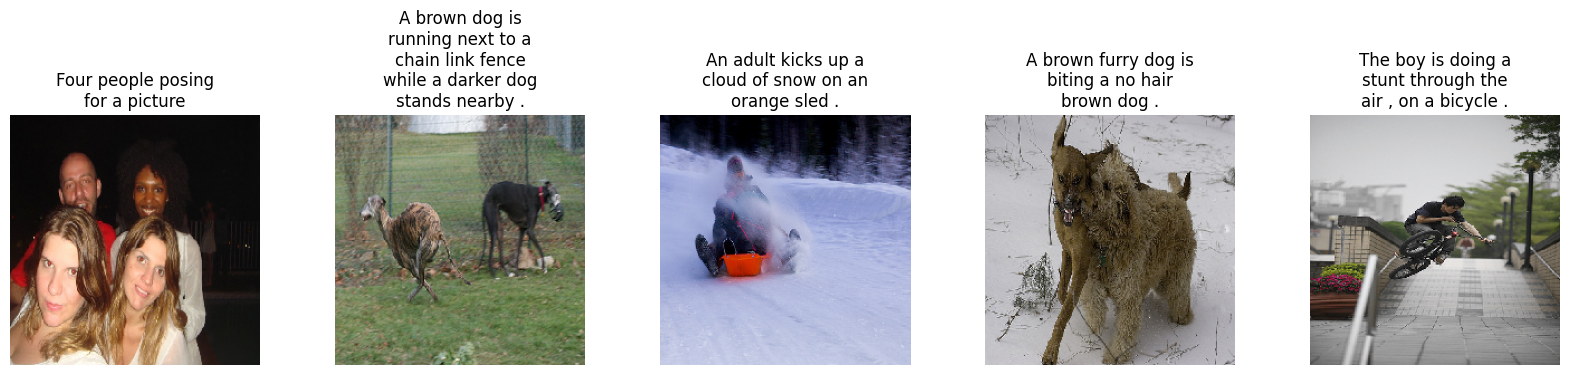

In [6]:
def readImage(path, img_size=224):
    img = load_img(path, color_mode='rgb', target_size=(img_size,img_size))
    img = img_to_array(img)
    img = img/255.

    return img

def display_images(temp_df):
    temp_df = temp_df.reset_index(drop=True)
    plt.figure(figsize=(20, 20))
    n = 0
    for i in range(5):
        n += 1
        plt.subplot(1, 5, n)
        plt.subplots_adjust(hspace=0.5, wspace=0.3)
        image = readImage(f"/content/Images/{temp_df.image[i]}")
        plt.imshow(image)
        plt.title("\n".join(wrap(temp_df.caption[i], 20)))
        plt.axis("off")

display_images(data.sample(5))

#### Text preprocessing

In [7]:
def text_preprocessing(data):
    data['caption'] = data['caption'].apply(lambda x: x.lower())
    data['caption'] = data['caption'].apply(lambda x: x.replace("[^A-Za-z]",""))
    data['caption'] = data['caption'].apply(lambda x: x.replace("\s+"," "))
    data['caption'] = data['caption'].apply(lambda x: " ".join([word for word in x.split() if len(word)>1]))
    data['caption'] = "startseq "+ data['caption'] +" endseq"
    return data

data = text_preprocessing(data)
captions = data['caption'].tolist()
captions[:5]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq']

#### Tokenizer setup

In [8]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(captions)

vocab_size = len(tokenizer.word_index) + 1
max_length = max(len(caption.split()) for caption in captions)

images = data['image'].unique().tolist()
nimages = len(images)

split_index = round(0.80*nimages)
train_images = images[:split_index]
val_images = images[split_index:]

train = data[data['image'].isin(train_images)]
test = data[data['image'].isin(val_images)]

train.reset_index(inplace=True,drop=True)
test.reset_index(inplace=True,drop=True)

tokenizer.texts_to_sequences([captions[1]])[0]

[1, 18, 315, 63, 195, 116, 2]

#### Data generator

In [9]:
class CustomDataGenerator(Sequence):
    def __init__(self, df, X_col, y_col, batch_size, directory, tokenizer,
                 vocab_size, max_length, features, shuffle=True):
        self.df = df.copy()
        self.X_col = X_col
        self.y_col = y_col
        self.directory = directory
        self.batch_size = batch_size
        self.tokenizer = tokenizer
        self.vocab_size = vocab_size
        self.max_length = max_length
        self.features = features
        self.shuffle = shuffle
        self.n = len(self.df)

    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)

    def __len__(self):
        return self.n // self.batch_size

    def __getitem__(self, index):
        batch = self.df.iloc[index * self.batch_size:(index + 1) * self.batch_size, :]
        X1, X2, y = self.__get_data(batch)
        return (X1, X2), y

    def __get_data(self, batch):
        X1, X2, y = list(), list(), list()
        images = batch[self.X_col].tolist()

        for image in images:
            feature = self.features[image][0]
            captions = batch.loc[batch[self.X_col] == image, self.y_col].tolist()
            for caption in captions:
                seq = self.tokenizer.texts_to_sequences([caption])[0]

                for i in range(1, len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=self.max_length)[0]
                    out_seq = to_categorical([out_seq], num_classes=self.vocab_size)[0]

                    X1.append(feature)
                    X2.append(in_seq)
                    y.append(out_seq)

        X1, X2, y = np.array(X1), np.array(X2), np.array(y)

        return X1, X2, y

#### Model compilation and summary

In [10]:
model = DenseNet201()

fe = Model(inputs=model.input, outputs=model.layers[-2].output)
img_size = 224
features = {}

for image in tqdm(data['image'].unique().tolist()):
    img = load_img(os.path.join(data_path, image), target_size=(img_size, img_size))
    img = img_to_array(img)
    img = img / 255.
    img = np.expand_dims(img, axis=0)
    feature = fe.predict(img, verbose=0)
    features[image] = feature

82524592/82524592 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


100%|██████████| 8091/8091 [14:47<00:00,  9.11it/s]


In [11]:
train_generator = CustomDataGenerator(
    df=train,
    X_col='image',
    y_col='caption',
    batch_size=64,
    directory=data_path,
    tokenizer=tokenizer,
    vocab_size=vocab_size,
    max_length=max_length,
    features=features
)

validation_generator = CustomDataGenerator(
    df=test,
    X_col='image',
    y_col='caption',
    batch_size=64,
    directory=data_path,
    tokenizer=tokenizer,
    vocab_size=vocab_size,
    max_length=max_length,
    features=features
)

In [12]:
input1 = Input(shape=(1920,))
input2 = Input(shape=(max_length,))

img_features = Dense(256, activation='relu')(input1)
img_features_reshaped = Reshape((1, 256), input_shape=(256,))(img_features)

sentence_features = Embedding(vocab_size, 256, mask_zero=False)(input2)
merged = concatenate([img_features_reshaped, sentence_features], axis=1)
sentence_features = LSTM(256)(merged)

x = Dropout(0.5)(sentence_features)
x = add([x, img_features])
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(vocab_size, activation='softmax')(x)

model = Model(inputs=[input1, input2], outputs=output)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 1920)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 256)            │        491,776 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_2             │ (None, 34)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape (Reshape)         │ (None, 1, 256)         │              0 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Embedding)     │ (None, 34, 256)        │      2,172,160 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 35, 256)        │              0 │ reshape[0][0],         │
│                           │                        │                │ embedding[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm (LSTM)               │ (None, 256)            │        525,312 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 256)            │              0 │ lstm[0][0]             │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 256)            │              0 │ dropout[0][0],         │
│                           │                        │                │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 128)            │         32,896 │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 128)            │              0 │ dense_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 8485)           │      1,094,565 │ dropout_1[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 4,316,709 (16.47 MB)

 Trainable params: 4,316,709 (16.47 MB)

 Non-trainable params: 0 (0.00 B)

#### Model training

In [13]:
model_name = "model.keras"
checkpoint = ModelCheckpoint(
    model_name,
    monitor="val_loss",
    mode="min",
    save_best_only=True,
    verbose=1
)

earlystopping = EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=5,
    verbose=1,
    restore_best_weights=True
)

learning_rate_reduction = ReduceLROnPlateau(
    monitor='val_loss',
    patience=3,
    verbose=1,
    factor=0.2,
    min_lr=1e-8
)

In [14]:
history = model.fit(
    train_generator,
    epochs=50,
    validation_data=validation_generator,
    callbacks=[checkpoint, earlystopping, learning_rate_reduction]
)

Epoch 1/50
505/505 ━━━━━━━━━━━━━━━━━━━━ 0s 577ms/step - accuracy: 0.1355 - loss: 5.7225
Epoch 1: val_loss improved from inf to 4.23705, saving model to model.keras
505/505 ━━━━━━━━━━━━━━━━━━━━ 372s 715ms/step - accuracy: 0.1356 - loss: 5.7212 - val_accuracy: 0.2461 - val_loss: 4.2370 - learning_rate: 0.0010
Epoch 2/50
505/505 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - accuracy: 0.2481 - loss: 4.2307
Epoch 2: val_loss improved from 4.23705 to 3.93255, saving model to model.keras
505/505 ━━━━━━━━━━━━━━━━━━━━ 96s 189ms/step - accuracy: 0.2481 - loss: 4.2306 - val_accuracy: 0.2761 - val_loss: 3.9326 - learning_rate: 0.0010
Epoch 3/50
505/505 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - accuracy: 0.2708 - loss: 3.9233
Epoch 3: val_loss improved from 3.93255 to 3.79819, saving model to model.keras
505/505 ━━━━━━━━━━━━━━━━━━━━ 100s 195ms/step - accuracy: 0.2708 - loss: 3.9232 - val_accuracy: 0.2908 - val_loss: 3.7982 - learning_rate: 0.0010
Epoch 4/50
505/505 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - accuracy: 

#### Model evaluation

In [16]:
best_val_accuracy = max(history.history['val_accuracy'])
print(f"Accuracy of the model: {best_val_accuracy:.4f}")

Accuracy of the model: 0.3223


#### Accuracy and loss over epochs

In [17]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

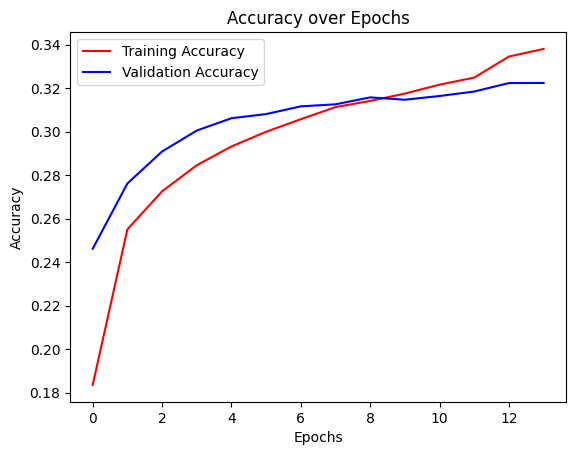

In [18]:
plt.plot(epochs_range, acc, label='Training Accuracy', color='red')
plt.plot(epochs_range, val_acc, label='Validation Accuracy', color='blue')
plt.legend(loc=0)
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

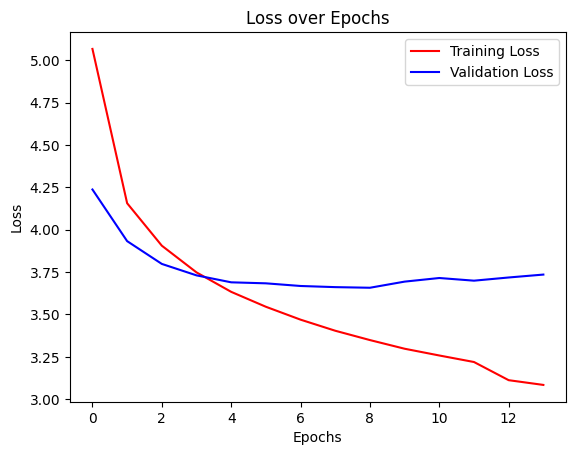

In [19]:
plt.plot(epochs_range, loss, label='Training Loss', color='red')
plt.plot(epochs_range, val_loss, label='Validation Loss', color='blue')
plt.legend(loc=0)
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

#### Model prediction

In [23]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

def predict_caption(model, image, tokenizer, max_length, features):
    feature_key = os.path.basename(image)

    if feature_key not in features:
        raise KeyError(f"Feature for {feature_key} not found in the features dictionary.")

    feature = features[feature_key]
    in_text = "startseq"

    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)

        y_pred = model.predict([feature, sequence], verbose=0)
        y_pred = np.argmax(y_pred)

        word = idx_to_word(y_pred, tokenizer)

        if word is None:
            break

        in_text += " " + word

        if word == 'endseq':
            break

    final_caption = in_text.replace("startseq", "").replace("endseq", "").strip()
    return final_caption

def display_image_and_caption(data_path, image_name, caption):
    img = mpimg.imread(os.path.join(data_path, image_name))

    plt.figure(figsize=(8, 8))
    plt.imshow(img)
    plt.axis('off')
    plt.title(caption, fontsize=14)
    plt.show()

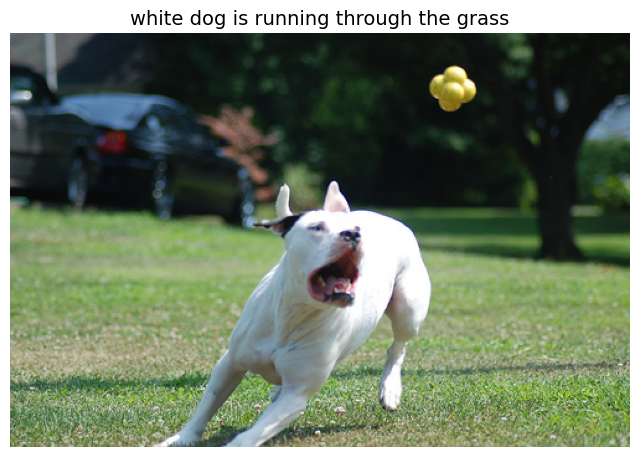

In [24]:
image_path = '/content/Images/1019604187_d087bf9a5f.jpg'
caption = predict_caption(model, image_path, tokenizer, max_length, features)
display_image_and_caption(data_path, os.path.basename(image_path), caption)